# Config

In [1]:
%%time

!pip install --upgrade --quiet git+https://github.com/qubvel/segmentation_models.pytorch
!pip install --quiet git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install --quiet torchinfo
!pip install --quiet neptune-notebooks
!pip install --quiet neptune-client
!pip install --upgrade --quiet timm
!pip install --quiet pretrainedmodels
!pip install --quiet yacs

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

segmentation-models-pytorch 0.1.3 requires timm==0.3.2, but you'll have timm 0.4.5 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upg

In [4]:
class CFG:
    debug=False
    external_data=False
    img_size=256
    new_size=256
    reduce = 4
    lr=1e-3
    batch_size=64
    epochs=20
    seed=42
    target_size=1
    n_fold=5
    warmup_epoch = 5
    warmup_factor = 1
    max_norm=0.5
    norm_type = 2.0
    T_max = 16
    min_lr=1e-6
    factor=0.7
    patience=2
    eps=1e-6
    scheduler='StepLR'
    fine_tune=False
    pseudo_label=False
    
resume=False
fp16=True
tta=True

# Data Loading

In [5]:
import glob, os
import numpy as np 
import pandas as pd 
from pathlib import Path
from tqdm import tqdm
import cv2

In [6]:
print(len(os.listdir('../input/hubmap-pseudo-labels/drive/MyDrive/colab/hubmap/pseudo_label_dir/')))

13137


In [7]:
outdir = Path('.')

if CFG.external_data:   
    datadir =f'../input/hubmap-{CFG.img_size}x{CFG.img_size}'
    train_imgs = os.listdir(datadir+'/train_images/kaggle/train_images')
    
    ext_datadir ='../input/glomeruli-hubmap-external-1024x1024'
    ext_train_imgs = os.listdir(ext_datadir+'/images_1024/')
    
    train_filelist = train_imgs
    
    ext_trainlist = ext_train_imgs
    
    slice_id, img_ids, img_paths, mask_paths, mask_density = [], [], [], [], []
    
    for filename in tqdm(train_filelist, total=len(train_filelist)):
        img_id = filename.split('.')
        slc_id = str(img_id[0]).split('_')
        slice_id.append(slc_id[0])
        img_ids.append(img_id[0])
        mask = np.load(f'{datadir}/train_masks/kaggle/train_masks/{img_id[0]}_mask.npy')
        mask_density.append(cv2.countNonZero(mask))
        img_paths.append(f'{datadir}/train_images/kaggle/train_images/{img_id[0]}.png')
        mask_paths.append(f'{datadir}/train_masks/kaggle/train_masks/{img_id[0]}_mask.npy')
        
    for filename in tqdm(ext_trainlist, total=len(ext_trainlist)):
        img_id = filename.split('.')
        img_ids.append(img_id[0])
        slc_id = str(img_id[0]).split('_')
        slice_id.append(f'{slc_id[0]}_{slc_id[1]}_{slc_id[2]}')
        mask = cv2.imread(f'{ext_datadir}/masks_1024/{img_id[0]}.png')
        mask_density.append(cv2.countNonZero(mask))
        img_paths.append(f'{ext_datadir}/images_1024/{img_id[0]}.png')
        mask_paths.append(f'{ext_datadir}/masks_1024/{img_id[0]}.png')
        
        
    print("number of images:", len(img_ids))
    print("number of masks:", len(img_paths))
        
    print(img_ids[:5])
    print(slice_id[:5])
    
    df = pd.DataFrame({'slice_id':slice_id, 'image_id':img_ids,'mask_density':mask_density, 'image_path':img_paths, 'mask_path':mask_paths})
    
    Q=100
    df['bin_label'] = pd.qcut(df[df['mask_density'] > 0]['mask_density'], q = Q, labels = False)
    df = df.fillna(-1.0)
    df['bin_label'] = df['bin_label'] + 1.0
    df.to_csv('train_processed.csv',index=False)
    
    train_csv = pd.read_csv('train_external.csv')
    display(train_csv.head())
    
else:
    datadir =f'../input/hubmap-{CFG.img_size}x{CFG.img_size}'

    train_imgs = os.listdir(datadir+'/train_images/kaggle/train_images')
    train_masks = os.listdir(datadir+'/train_masks/kaggle/train_masks')

    train_csv = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
    print("number of unique tiff files",len(train_csv))

    filelist = train_imgs
    
    slice_id, img_ids, img_paths, mask_paths, mask_density = [], [], [], [], []
    
    for filename in tqdm(filelist, total=len(filelist)):
        img_id = filename.split('.')
        slc_id = str(img_id[0]).split('_')
        slice_id.append(slc_id[0])
        img_ids.append(img_id[0])
        mask = np.load(f'{datadir}/train_masks/kaggle/train_masks/{img_id[0]}_mask.npy')
        mask_density.append(cv2.countNonZero(mask))
        img_paths.append(f'{datadir}/train_images/kaggle/train_images/{img_id[0]}.png')
        mask_paths.append(f'{datadir}/train_masks/kaggle/train_masks/{img_id[0]}_mask.npy')
        
    print("number of images:", len(img_paths))
    print("number of masks:", len(mask_paths))
    
    df = pd.DataFrame({'slice_id':slice_id, 'image_id':img_ids,'mask_density':mask_density, 'image_path':img_paths, 'mask_path':mask_paths})
    
    Q=100
    df['bin_label'] = pd.qcut(df[df['mask_density'] > 0]['mask_density'], q = Q, labels = False)
    df = df.fillna(-1.0)
    df['bin_label'] = df['bin_label'] + 1.0
    df.to_csv('train_processed.csv',index=False)
    
    train_csv = pd.read_csv('train_processed.csv')

    print(img_ids[:5])

    display(train_csv.head())

  0%|          | 15/13137 [00:00<01:32, 141.76it/s]

number of unique tiff files 15


100%|██████████| 13137/13137 [01:12<00:00, 181.51it/s]


number of images: 13137
number of masks: 13137
['26dc41664_595', '2ec3f1bb9_625', 'b2dc8411c_355', 'aa05346ff_1188', 'aa05346ff_90']


,slice_id,image_id,mask_density,image_path,mask_path,bin_label
0,26dc41664,26dc41664_595,0,../input/hubmap-256x256/train_images/kaggle/tr...,../input/hubmap-256x256/train_masks/kaggle/tra...,0.0
1,2ec3f1bb9,2ec3f1bb9_625,2861,../input/hubmap-256x256/train_images/kaggle/tr...,../input/hubmap-256x256/train_masks/kaggle/tra...,32.0
2,b2dc8411c,b2dc8411c_355,0,../input/hubmap-256x256/train_images/kaggle/tr...,../input/hubmap-256x256/train_masks/kaggle/tra...,0.0
3,aa05346ff,aa05346ff_1188,0,../input/hubmap-256x256/train_images/kaggle/tr...,../input/hubmap-256x256/train_masks/kaggle/tra...,0.0
4,aa05346ff,aa05346ff_90,0,../input/hubmap-256x256/train_images/kaggle/tr...,../input/hubmap-256x256/train_masks/kaggle/tra...,0.0


# Library

In [8]:
# ====================================================
# Library
# ====================================================

import os
import sys
import gc
import random
import time
import logging
import json
from functools import partial
from tqdm import tqdm
from time import perf_counter
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter
from IPython.core.display import display, HTML

import skimage.io
import cv2
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn import init, Sequential
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR, OneCycleLR
from torch.cuda.amp import *
from warmup_scheduler import GradualWarmupScheduler
from torch.utils.data import DataLoader, Dataset

import timm
import pretrainedmodels
import torchvision.transforms as TF
import segmentation_models_pytorch as smp
from unet_model import *

from albumentations import *
from albumentations.pytorch import ToTensorV2

from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split

from lovasz import lovasz_hinge

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import neptune
neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
             project_qualified_name=os.getenv('NEPTUNE_PROJECT'))

params={'epochs': CFG.epochs,
        'batch_size': CFG.batch_size,
        'image_size': (CFG.img_size,CFG.img_size),
        'lr': CFG.lr}

neptune.create_experiment(name='kaggle_train_hubmap', params=params)

# Utils

In [12]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('HUBMAP')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_torch(seed=42)

# Dataset

In [14]:
def get_transforms(*, data, p=1.0):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomRotate90(p=0.5),
            #RandomResizedCrop(CFG.img_size, CFG.img_size, p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.6, 
                             border_mode=cv2.BORDER_REFLECT),
            Cutout(num_holes=4, max_h_size=30, max_w_size=30, fill_value=255, always_apply=False, p=0.2),
            #GridDropout (ratio=0.5, unit_size_min=None, unit_size_max=None, holes_number_x=None, holes_number_y=None, 
            #             shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=0, always_apply=False, p=0.1),
            MaskDropout (max_objects=1, image_fill_value=255, mask_fill_value=0, always_apply=False, p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.2),
                IAAPiecewiseAffine(p=0.3),
                #ElasticTransform (alpha=1, value=255, mask_value=0, always_apply=False, approximate=False, p=0.1),
            ], p=0.4),
            OneOf([
                HueSaturationValue(10,15,10, p=0.3),
                CLAHE(clip_limit=2, p=0.3),
                RandomBrightnessContrast(p=0.3), 
                #ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.1),
            ], p=0.4),
        ], p=p)
    
    elif data == 'valid':
        return Compose([
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            #ToTensorV2(),
        ])

In [16]:
mean=np.asarray([0.485, 0.456, 0.406])
std=np.asarray([0.229, 0.224, 0.225])

class KidneyDataset(Dataset):
    def __init__(self, df, mode='train', transform=None, rand=False):
        self.df = df
        self.mode = mode
        self.transform = transform
        self.rand = rand
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row.image_id
        
        if CFG.external_data:
            img_path = row.image_path
            mask_path = row.mask_path
            
            img = cv2.imread(img_path)
            if '.npy' in mask_path:
                mask = np.load(mask_path)
            else:
                mask = cv2.imread(mask_path)
                mask = cv2.resize(mask, (CFG.img_size,CFG.img_size), interpolation = cv2.INTER_AREA)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (CFG.img_size,CFG.img_size), interpolation = cv2.INTER_AREA)
        else:    
            img_path = f'{datadir}/train_images/kaggle/train_images/{img_id}.png'
            if CFG.pseudo_label:
                mask_path = f'../input/hubmap-pseudo-labels/drive/MyDrive/colab/hubmap/pseudo_label_dir/{img_id}_mask.npy'
            else:
                mask_path = f'{datadir}/train_masks/kaggle/train_masks/{img_id}_mask.npy'

            img = cv2.imread(img_path)
            mask = np.load(mask_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            transformed_image = transformed['image']#.permute(2,1,0)
            transformed_mask  = transformed['mask']
            
        image = torch.tensor(transformed_image, dtype=torch.float32)
        image = (image/255.0 - mean)/std
        
        image = cv2.resize(np.array(image), (CFG.new_size, CFG.new_size), interpolation = cv2.INTER_AREA)
        transformed_mask = cv2.resize(np.array(transformed_mask), (CFG.new_size, CFG.new_size), interpolation = cv2.INTER_AREA)
            
        image = np.transpose(image, (2,0,1))
        mask = np.reshape(transformed_mask, (CFG.new_size,CFG.new_size,1))
        mask = np.transpose(mask, (2,0,1))
        
              
        if self.mode == 'train' or self.mode == 'valid':
            return torch.tensor(image), torch.tensor(mask, dtype=torch.uint8)
        else:
            return torch.tensor(image)

In [17]:
train_dataset = KidneyDataset(train_csv, mode='train',transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256, 3])


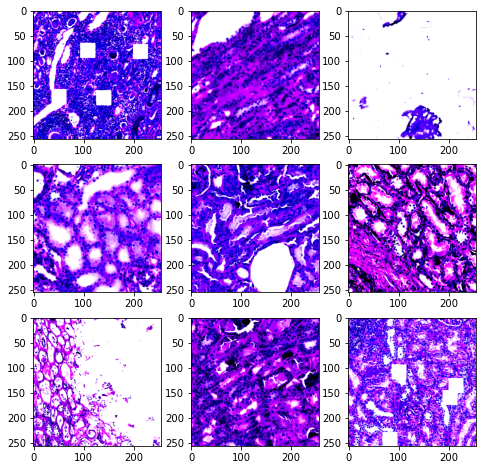

In [18]:
for image, mask in train_loader:
    print(image.shape)
    print(mask.shape)
    image = image.permute(0,2,3,1)
    print(image.shape)
    break

w=5
h=5
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = image[i]#*std + mean
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

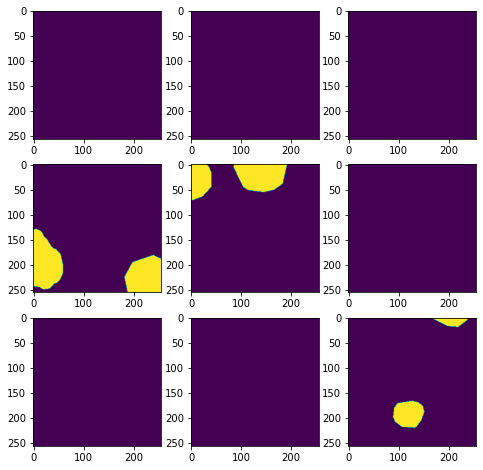

In [19]:
w=5
h=5
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = mask[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0])
plt.show()

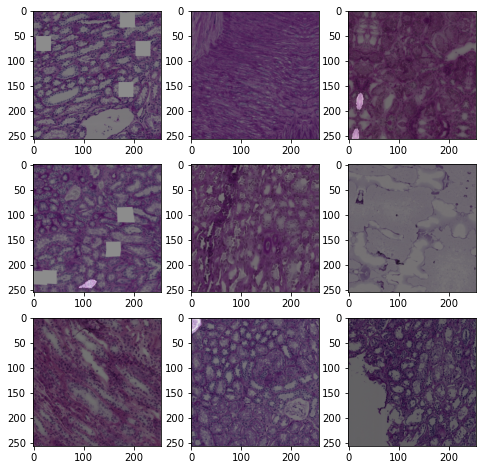

In [20]:
alpha = 0.55
beta = (1.0 - alpha)

for image, mask in train_loader:
    image = image.permute(0,2,3,1)
    break

w=5
h=5
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.array((image[i]*std + mean)).astype(float)
    msk = mask[i]
    msk = cv2.cvtColor(np.array(msk.permute(1,2,0)), cv2.COLOR_GRAY2RGB)
    msk = np.array(msk).astype(float)
    dst = cv2.addWeighted(img, alpha, msk, beta, 0.0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(dst)
plt.show()

In [22]:
del train_loader, train_dataset
gc.collect()

70

In [23]:
hubmap = pd.read_csv('../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv')
hubmap.head()

FE = ['id','age','race','sex','laterality', 'weight_kilograms','height_centimeters','bmi_kg/m^2','percent_cortex','percent_medulla']
        
le = preprocessing.LabelEncoder()
le.fit(["Male", "Female"])
hubmap['sex'] = le.fit_transform(hubmap['sex'])

hubmap['id'] = hubmap['image_file'].str.split(".", n = 1, expand = True)[0]
features = hubmap[FE]
features.head()

,id,age,race,sex,laterality,weight_kilograms,height_centimeters,bmi_kg/m^2,percent_cortex,percent_medulla
0,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20
1,afa5e8098,58,White,0,Right,59.0,160.0,23.0,55,45
2,54f2eec69,58,Black or African American,1,Right,79.9,190.5,22.0,75,25
3,d488c759a,66,White,0,Left,81.5,158.8,32.2,100,0
4,1e2425f28,48,White,1,Right,131.5,193.0,35.3,65,35


In [24]:
image_paths = pd.DataFrame(data=img_ids, columns=['image_id'])
new = image_paths['image_id'].str.split("_", n = 1, expand = True)

image_paths['id'] = new[0]
image_paths['slice'] = new[1]
image_paths = image_paths.drop(['image_id'], axis=1)
image_paths.head()

,id,slice
0,26dc41664,595
1,2ec3f1bb9,625
2,b2dc8411c,355
3,aa05346ff,1188
4,aa05346ff,90


In [25]:
merged = pd.merge(features, image_paths, on='id')

In [26]:
df1 = merged[merged.isna().any(axis=1)]
df1.head()

,id,age,race,sex,laterality,weight_kilograms,height_centimeters,bmi_kg/m^2,percent_cortex,percent_medulla,slice
8625,aaa6a05cc,73,White,0,Left,NaN,NaN,NaN,75,25,166
8626,aaa6a05cc,73,White,0,Left,NaN,NaN,NaN,75,25,190
8627,aaa6a05cc,73,White,0,Left,NaN,NaN,NaN,75,25,192
8628,aaa6a05cc,73,White,0,Left,NaN,NaN,NaN,75,25,47
8629,aaa6a05cc,73,White,0,Left,NaN,NaN,NaN,75,25,97


In [27]:
merged['image_id'] = merged['id'].str.cat(merged['slice'],sep="_")
merged = merged.dropna(subset=['slice'])
merged.reset_index(drop=True)
merged.head()

,id,age,race,sex,laterality,weight_kilograms,height_centimeters,bmi_kg/m^2,percent_cortex,percent_medulla,slice,image_id
0,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20,1188,aa05346ff_1188
1,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20,90,aa05346ff_90
2,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20,1155,aa05346ff_1155
3,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20,275,aa05346ff_275
4,aa05346ff,58,White,0,Right,59.0,160.0,23.0,80,20,640,aa05346ff_640


In [28]:
# skf = StratifiedKFold(n_splits=CFG.n_fold, random_state=CFG.seed, shuffle=False)
# train_csv['fold'] = -1
# for i, (train_idx, valid_idx) in enumerate(skf.split(train_csv, train_csv['bin_label'])):
#     train_csv.loc[valid_idx, 'fold'] = i

In [29]:
gkf = GroupKFold(n_splits=CFG.n_fold)
groups = train_csv['slice_id']
train_csv['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(gkf.split(train_csv, train_csv['image_id'], groups)):
    train_csv.loc[valid_idx, 'fold'] = i

In [30]:
# kf = KFold(n_splits=5, random_state=CFG.seed, shuffle=False)
# merged['fold'] = -1
# for i, (train_idx, valid_idx) in enumerate(kf.split(merged, merged['image_id'])):
#     merged.loc[valid_idx, 'fold'] = i

In [31]:
train_csv.head()

,slice_id,image_id,mask_density,image_path,mask_path,bin_label,fold
0,26dc41664,26dc41664_595,0,../input/hubmap-256x256/train_images/kaggle/train_images/26dc41664_595.png,../input/hubmap-256x256/train_masks/kaggle/train_masks/26dc41664_595_mask.npy,0.0,4
1,2ec3f1bb9,2ec3f1bb9_625,2861,../input/hubmap-256x256/train_images/kaggle/train_images/2ec3f1bb9_625.png,../input/hubmap-256x256/train_masks/kaggle/train_masks/2ec3f1bb9_625_mask.npy,32.0,3
2,b2dc8411c,b2dc8411c_355,0,../input/hubmap-256x256/train_images/kaggle/train_images/b2dc8411c_355.png,../input/hubmap-256x256/train_masks/kaggle/train_masks/b2dc8411c_355_mask.npy,0.0,3
3,aa05346ff,aa05346ff_1188,0,../input/hubmap-256x256/train_images/kaggle/train_images/aa05346ff_1188.png,../input/hubmap-256x256/train_masks/kaggle/train_masks/aa05346ff_1188_mask.npy,0.0,0
4,aa05346ff,aa05346ff_90,0,../input/hubmap-256x256/train_images/kaggle/train_images/aa05346ff_90.png,../input/hubmap-256x256/train_masks/kaggle/train_masks/aa05346ff_90_mask.npy,0.0,0


# Model

In [32]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        #m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
        #                   'resnext50_32x4d_ssl')
        self.m = timm.create_model('seresnext50_32x4d', pretrained=True)
        self.enc0 = nn.Sequential(self.m.conv1, self.m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            self.m.layer1) #256
        self.enc2 = self.m.layer2 #512
        self.enc3 = self.m.layer3 #1024
        self.enc4 = self.m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.3)#0.1
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x
    
#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

In [36]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = True
    # To freeze the resnet layers
    for param in model.encoder.parameters():
    #for param in model.m.parameters():
        param.requires_grad = False
        
    return model

def unfreeze(model):
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    return model

In [38]:
# from sklearn.metrics import cohen_kappa_score

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return dice
        #return 1 - dice
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=0):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        loss = BCE + dice_loss
        
        return loss
    
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def focal_lovaz(outputs, targets):
    focal_loss = FocalLoss()
    return focal_loss(outputs, targets) + lovasz_hinge(outputs, targets)

def dice_bce(outputs, targets):
    d_loss = DiceLoss()
    return d_loss(outputs, targets) + F.binary_cross_entropy(outputs, targets)
    
# def dice_loss(input, target):
#     input = torch.sigmoid(input)
#     smooth = 1.0

#     iflat = input.view(-1)
#     tflat = target.view(-1)
#     intersection = (iflat * tflat).sum()
    
#     return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# class FocalLoss(nn.Module):
#     def __init__(self, gamma):
#         super().__init__()
#         self.gamma = gamma
        
#     def forward(self, input, target):
#         if not (target.size() == input.size()):
#             raise ValueError("Target size ({}) must be the same as input size ({})"
#                              .format(target.size(), input.size()))

#         max_val = (-input).clamp(min=0)
#         loss = input - input * target + max_val + \
#             ((-max_val).exp() + (-input - max_val).exp()).log()

#         invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
#         loss = (invprobs * self.gamma).exp() * loss
        
#         return loss.mean()

# class MixedLoss(nn.Module):
#     def __init__(self, alpha, gamma):
#         super().__init__()
#         self.alpha = alpha
#         self.focal = FocalLoss(gamma)
        
#     def forward(self, input, target):
#         loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
#         return loss.mean()
    
# def dice(pred, targs):
#     pred = (pred>0).float()
#     return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

# def IoU(pred, targs):
#     pred = (pred>0).float()
#     intersection = (pred*targs).sum()
#     return intersection / ((pred+targs).sum() - intersection + 1.0)

In [39]:
def get_dice(y_pred, y_true):
    intersection = torch.tensor((y_pred * y_true).float().sum())
    union = torch.tensor((y_true + y_pred).float().sum())
    
    dice = torch.where(union > 0.0, 2.0*intersection/union, 
                            torch.zeros_like(union))

    return dice

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))
   
def FocalTverskyLoss(inputs, targets, smooth=1.0, alpha=0.7, gamma=0.75):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FN + (1 - alpha)*FP + smooth)  
        loss = (1 - Tversky)**gamma
                       
        return loss

#metric = smp.utils.losses.DiceLoss()

In [40]:
# eps = 1e-6


# def soft_dice_loss(outputs, targets, per_image=False, per_channel=False):
#     batch_size, n_channels = outputs.size(0), outputs.size(1)
    
#     eps = 1e-6
#     n_parts = 1
#     if per_image:
#         n_parts = batch_size
#     if per_channel:
#         n_parts = batch_size * n_channels
    
#     dice_target = targets.contiguous().view(n_parts, -1).float()
#     dice_output = outputs.contiguous().view(n_parts, -1)
#     intersection = torch.sum(dice_output * dice_target, dim=1)
#     union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
#     loss = (1 - (2 * intersection + eps) / union).mean()
#     return loss

# def dice_metric(preds, trues, per_image=False, per_channel=False):
#     preds = preds.float()
#     return 1 - soft_dice_loss(preds, trues, per_image, per_channel)


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True, per_image=False):
#         super().__init__()
#         self.size_average = size_average
#         self.register_buffer('weight', weight)
#         self.per_image = per_image

#     def forward(self, input, target):
#         return soft_dice_loss(input, target, per_image=self.per_image)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=True, non_empty=False, apply_sigmoid=True,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)


# class StableBCELoss(nn.Module):
#     def __init__(self):
#         super(StableBCELoss, self).__init__()

#     def forward(self, input, target):
#         input = input.float().view(-1)
#         target = target.float().view(-1)
#         neg_abs = - input.abs()
#         # todo check correctness
#         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
#         return loss.mean()


# class ComboLoss(nn.Module):
#     def __init__(self, weights, per_image=False, channel_weights=[1, 0.5, 0.5], channel_losses=None):
#         super().__init__()
#         self.weights = weights
#         self.bce = StableBCELoss()
#         self.dice = DiceLoss(per_image=False)
#         self.jaccard = JaccardLoss(per_image=False)
#         self.lovasz = LovaszLoss(per_image=per_image)
#         self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
#         self.focal = FocalLoss2d()
#         self.mapping = {'bce': self.bce,
#                         'dice': self.dice,
#                         'focal': self.focal,
#                         'jaccard': self.jaccard,
#                         'lovasz': self.lovasz,
#                         'lovasz_sigmoid': self.lovasz_sigmoid}
#         self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
#         self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
#         self.values = {}
#         self.channel_weights = channel_weights
#         self.channel_losses = channel_losses

#     def forward(self, outputs, targets):
#         loss = 0
#         weights = self.weights
#         sigmoid_input = torch.sigmoid(outputs)
#         for k, v in weights.items():
#             if not v:
#                 continue
#             val = 0
#             if k in self.per_channel:
#                 channels = targets.size(1)
#                 for c in range(channels):
#                     if not self.channel_losses or k in self.channel_losses[c]:
#                         val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
#                                                targets[:, c, ...])

#             else:
#                 val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

#             self.values[k] = val
#             loss += self.weights[k] * val
#         return loss.clamp(min=1e-5)


In [41]:
# From https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        #score = -val_loss
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss
        
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
# dice with automatic threshold selection
class Dice_th():
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        pred,targ = flatten_check(torch.sigmoid(p), t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()
        
class Dice_th_pred():
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        #pred, targ = p, t
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices

In [42]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [43]:
def train(epoch, model):
    model.train()
    
    if CFG.fine_tune:
        if epoch<4:
            model = freeze(model)
        else:
            model = unfreeze(model)
    
    avg_train_loss = AverageMeter()
    score = AverageMeter()

    optimizer.zero_grad()

    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in bar:
        
        data, target = data.to(device).float(), target.to(device).float()
        
        optimizer.zero_grad()
                
        if fp16:
            with autocast():
                logits = model(data).float()
                #loss = symmetric_lovasz(logits, target)
                loss = criterion(logits, target)

            kaggle_metric = get_dice(logits.sigmoid().detach().float(), target.detach().float())
            score.update(kaggle_metric)

            scaler.scale(loss).backward()
            
            # Clip gradients
            if CFG.max_norm is not None:
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_norm, CFG.norm_type)
                
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(data).float()
            #loss = symmetric_lovasz(logits, target)
            loss = criterion(logits, target)
                
            kaggle_metric = get_dice(logits.sigmoid().detach().float(), target.detach().float())
            score.update(kaggle_metric)
            
            loss.backward()
            
            optimizer.step()
        
        #scheduler.step()
        avg_train_loss.update(loss.detach().item())
        
        bar.set_description('average loss: %.5f' % (avg_train_loss.avg))
        neptune.send_metric('lr_iter', optimizer.param_groups[0]['lr'])

    
    neptune.send_metric('train_loss', avg_train_loss.avg)
    neptune.send_metric('train_dice_score', score.avg)
    neptune.send_metric('lr', optimizer.param_groups[0]['lr'])
    torch.cuda.empty_cache()
    gc.collect()
    return avg_train_loss.avg, score.avg

In [44]:
def valid(epoch, model):
    model.eval()
    avg_val_loss = AverageMeter()
    score = AverageMeter()
    preds = []
    valid_labels = []
    tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

    for i, (data, target) in tk1:

        data = data.to(device).float()
        target = target.to(device).float()

        with torch.no_grad():
            logits = model(data).float()
            pred = logits.sigmoid().detach().float()
            
        kaggle_metric = get_dice(pred.detach().float(), target.detach().float())
        score.update(kaggle_metric)

        #loss = symmetric_lovasz(logits, target)
        loss = criterion(logits, target)
        avg_val_loss.update(loss.detach().item())
       
    #scheduler.step(avg_val_loss)
    
    neptune.send_metric('valid_loss', avg_val_loss.avg)
    neptune.send_metric('valid_dice_score', score.avg)
    torch.cuda.empty_cache()
    gc.collect()

    return avg_val_loss.avg, score.avg

In [45]:
def run_main(epochs):
    best_score = 0
    best_loss = np.inf
    #best_preds = None
    for epoch in range(1, epochs+1):
        start_time = time.time()
        torch.cuda.empty_cache()
        gc.collect()
        
        #print('lr:', optimizer.param_groups[0]["lr"])
        avg_train_loss, train_score = train(epoch, model) 
        avg_val_loss, valid_score = valid(epoch, model)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(valid_score)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, GradualWarmupSchedulerV2):
            scheduler.step()
        elif isinstance(scheduler, StepLR):
            scheduler.step()
        
        elapsed = time.time() - start_time
        LOGGER.debug(f'  Epoch {epoch} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch} - train_metric: {train_score}  valid_metric: {valid_score}')
        if valid_score>best_score:
            torch.save(model.state_dict(), f'model_fold_{fold}.pt')
            neptune.log_artifact(f'model_fold_{fold}.pt')
            #torch.save(model.state_dict(), 'model_{epoch:03}.pt'.format(epoch=epoch))
            best_score=valid_score

        checkpoint = {
            'epoch': epoch,
            'lr': optimizer.param_groups[0]['lr'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            #'amp': amp.state_dict()
            }
        torch.save(checkpoint, 'checkpoint.pt')
        #neptune.log_artifact('checkpoint.pt')
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return best_score

In [46]:
def oof_model_preds(test_loader, model):
    predictions, labels = [], []
    model.eval()
    dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
    
    tk1 = tqdm(enumerate(test_loader), total=len(test_loader))

    for i, (data, target) in tk1:
        data = data.to(device).float()
        idxs = []
        with torch.no_grad():
            preds=None
            logits = model(data)
            pred = torch.sigmoid(logits).detach()
            if preds is None: preds = pred
            else: preds += pred
            if tta:
                #x,y,xy flips as TTA
                flips = [[-1],[-2],[-2,-1]]
                for f in flips:
                    xf = torch.flip(data,f)
                    pred = model(xf)
                    pred = torch.flip(pred,f)
                    preds += torch.sigmoid(pred).detach()
                preds /= (1+len(flips))        
            #preds /= len(models)
            if target is not None and len(target.shape)==4 and preds.shape != target.shape:
                preds = F.upsample(preds, size=(target.shape[-2],target.shape[-1]), mode="bilinear")
            preds = preds.permute(0,2,3,1).float().cpu()
            
            predictions.append(preds)
            labels.append(target)
            
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)
            
    print("Finding optimum threshold...")
    for p,target_mask in zip(predictions,labels):
        mask = p.squeeze(-1).float()
        #mask = torch.tensor(mask, dtype=torch.int8)
        dice.accumulate(mask.float().cuda(),target_mask.float().cuda())
        
    torch.cuda.empty_cache()
    del idxs, preds, logits, mask, predictions, labels
    gc.collect()
    return dice

In [47]:
def oof_test(model, valid_loader):
    #manual_fold = [0,1,2]
    #for _,fold in enumerate(manual_fold):
    for fold in range(CFG.n_fold):
        print(f'OOF fold {fold}')

        state_dict = torch.load(f'model_fold_{fold}.pt',map_location=torch.device('cpu'))
        #model = smp.UnetPlusPlus('efficientnet-b4', encoder_weights=None, decoder_attention_type=None, classes=1).to(device)
        model = UneXt50().to(device)
        model.load_state_dict(state_dict)
        model.to(device)
        
        dice = oof_model_preds(valid_loader, model)

        dices = dice.value
        noise_ths = dice.ths
        best_dice = dices.max()
        best_thr = noise_ths[dices.argmax()]
        
        plt.figure(figsize=(8,4))
        plt.plot(noise_ths, dices, color='blue')
        plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
        d = dices.max() - dices.min()
        plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
        plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
        plt.title(f'fold_{fold}')
        plt.savefig(f'dice_thresh_fold_{fold}.png')
        plt.show()

        torch.cuda.empty_cache()
        gc.collect()

        LOGGER.debug(f' oof_fold {fold} - oof_dice: {best_dice}  oof_thr: {best_thr}')
        return best_dice, best_thr

In [49]:
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='GradualWarmupSchedulerV2':
        scheduler_cosine = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.warmup_epoch, after_scheduler=scheduler_cosine)
    elif CFG.scheduler=='StepLR':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.7, last_epoch=-1)
    elif CFG.scheduler=='OneCycle':
        scheduler = OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.45, cycle_momentum=True, steps_per_epoch=len(train_loader), epochs=CFG.epochs)
        
    return scheduler

Training fold 0


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth
2021-05-10 06:39:59,079 DEBUG Loading dataset...
  0%|          | 7/2576 [00:00<00:00, 25890.77it/s]
2021-05-10 06:39:59,098 DEBUG Loading dataset complete
100%|██████████| 41/41 [00:40<00:00,  1.01it/s]
2021-05-10 06:48:08,121 DEBUG   Epoch 1 - avg_train_loss: 0.0363  avg_val_loss: 0.0287  time: 489s
2021-05-10 06:48:08,123 DEBUG   Epoch 1 - train_metric: 0.7261391282081604  valid_metric: 0.7949519157409668
100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
2021-05-10 06:55:54,906 DEBUG   Epoch 2 - avg_train_loss: 0.0145  avg_val_loss: 0.0168  time: 436s
2021-05-10 06:55:54,911 DEBUG   Epoch 2 - train_metric: 0.8536972403526306  valid_metric: 0.8616153001785278
100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
2021-05-10 07:03:06,454 DEBUG   Epoch 3 - avg_train_loss: 0.0131  avg_val_loss

EarlyStopping counter: 1 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
2021-05-10 07:10:01,485 DEBUG   Epoch 4 - avg_train_loss: 0.0120  avg_val_loss: 0.0252  time: 414s
2021-05-10 07:10:01,490 DEBUG   Epoch 4 - train_metric: 0.8758347630500793  valid_metric: 0.7956963181495667


EarlyStopping counter: 2 out of 10


100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
2021-05-10 07:17:05,523 DEBUG   Epoch 5 - avg_train_loss: 0.0114  avg_val_loss: 0.0183  time: 422s
2021-05-10 07:17:05,539 DEBUG   Epoch 5 - train_metric: 0.8849126100540161  valid_metric: 0.8426892161369324


EarlyStopping counter: 3 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
2021-05-10 07:24:04,160 DEBUG   Epoch 6 - avg_train_loss: 0.0106  avg_val_loss: 0.0189  time: 417s
2021-05-10 07:24:04,163 DEBUG   Epoch 6 - train_metric: 0.8912290334701538  valid_metric: 0.8522902131080627


EarlyStopping counter: 4 out of 10


100%|██████████| 41/41 [00:30<00:00,  1.33it/s]
2021-05-10 07:31:09,155 DEBUG   Epoch 7 - avg_train_loss: 0.0103  avg_val_loss: 0.0192  time: 424s
2021-05-10 07:31:09,159 DEBUG   Epoch 7 - train_metric: 0.8908246159553528  valid_metric: 0.8451958298683167


EarlyStopping counter: 5 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.44it/s]
2021-05-10 07:38:03,627 DEBUG   Epoch 8 - avg_train_loss: 0.0093  avg_val_loss: 0.0188  time: 413s
2021-05-10 07:38:03,630 DEBUG   Epoch 8 - train_metric: 0.9004730582237244  valid_metric: 0.8565027117729187


EarlyStopping counter: 6 out of 10


100%|██████████| 41/41 [00:33<00:00,  1.24it/s]
2021-05-10 07:45:12,006 DEBUG   Epoch 9 - avg_train_loss: 0.0098  avg_val_loss: 0.0154  time: 427s
2021-05-10 07:45:12,009 DEBUG   Epoch 9 - train_metric: 0.896044135093689  valid_metric: 0.8709072470664978
100%|██████████| 41/41 [00:30<00:00,  1.34it/s]
2021-05-10 07:52:37,431 DEBUG   Epoch 10 - avg_train_loss: 0.0093  avg_val_loss: 0.0197  time: 422s
2021-05-10 07:52:37,434 DEBUG   Epoch 10 - train_metric: 0.8995482921600342  valid_metric: 0.831514298915863


EarlyStopping counter: 1 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
2021-05-10 07:59:38,490 DEBUG   Epoch 11 - avg_train_loss: 0.0088  avg_val_loss: 0.0161  time: 420s
2021-05-10 07:59:38,494 DEBUG   Epoch 11 - train_metric: 0.9033918380737305  valid_metric: 0.8760313987731934


EarlyStopping counter: 2 out of 10


100%|██████████| 41/41 [00:29<00:00,  1.38it/s]
2021-05-10 08:06:58,001 DEBUG   Epoch 12 - avg_train_loss: 0.0088  avg_val_loss: 0.0161  time: 421s
2021-05-10 08:06:58,011 DEBUG   Epoch 12 - train_metric: 0.9030957221984863  valid_metric: 0.8689443469047546


EarlyStopping counter: 3 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
2021-05-10 08:14:06,589 DEBUG   Epoch 13 - avg_train_loss: 0.0085  avg_val_loss: 0.0212  time: 427s
2021-05-10 08:14:06,593 DEBUG   Epoch 13 - train_metric: 0.9095508456230164  valid_metric: 0.8552475571632385


EarlyStopping counter: 4 out of 10


100%|██████████| 41/41 [00:33<00:00,  1.22it/s]
2021-05-10 08:21:15,663 DEBUG   Epoch 14 - avg_train_loss: 0.0086  avg_val_loss: 0.0164  time: 428s
2021-05-10 08:21:15,667 DEBUG   Epoch 14 - train_metric: 0.9082493185997009  valid_metric: 0.8764740228652954


EarlyStopping counter: 5 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.44it/s]
2021-05-10 08:28:31,577 DEBUG   Epoch 15 - avg_train_loss: 0.0083  avg_val_loss: 0.0182  time: 416s
2021-05-10 08:28:31,581 DEBUG   Epoch 15 - train_metric: 0.9095785021781921  valid_metric: 0.8563372492790222


EarlyStopping counter: 6 out of 10


100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
2021-05-10 08:35:29,281 DEBUG   Epoch 16 - avg_train_loss: 0.0081  avg_val_loss: 0.0164  time: 416s
2021-05-10 08:35:29,284 DEBUG   Epoch 16 - train_metric: 0.9118406772613525  valid_metric: 0.886916995048523


EarlyStopping counter: 7 out of 10


100%|██████████| 41/41 [00:26<00:00,  1.52it/s]
2021-05-10 08:42:29,018 DEBUG   Epoch 17 - avg_train_loss: 0.0079  avg_val_loss: 0.0159  time: 403s
2021-05-10 08:42:29,021 DEBUG   Epoch 17 - train_metric: 0.9145259857177734  valid_metric: 0.8656686544418335


EarlyStopping counter: 8 out of 10


100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
2021-05-10 08:49:27,021 DEBUG   Epoch 18 - avg_train_loss: 0.0080  avg_val_loss: 0.0176  time: 416s
2021-05-10 08:49:27,025 DEBUG   Epoch 18 - train_metric: 0.9136431813240051  valid_metric: 0.8584893941879272


EarlyStopping counter: 9 out of 10


100%|██████████| 41/41 [00:30<00:00,  1.33it/s]
2021-05-10 08:56:29,237 DEBUG   Epoch 19 - avg_train_loss: 0.0081  avg_val_loss: 0.0164  time: 421s
2021-05-10 08:56:29,239 DEBUG   Epoch 19 - train_metric: 0.9117283225059509  valid_metric: 0.878430187702179
2021-05-10 08:56:30,648 DEBUG   Best validation score 0.886916995048523


EarlyStopping counter: 10 out of 10
Early stopping
OOF fold 0


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Finding optimum threshold...


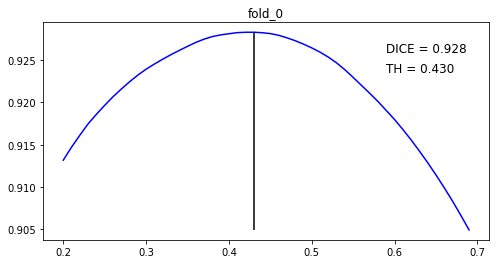

2021-05-10 08:58:14,562 DEBUG  oof_fold 0 - oof_dice: 0.9282777309417725  oof_thr: 0.4300000000000002


0

In [50]:
oof_score, oof_thr, oof_fold = [], [], []

#manual_fold = [0,1,2]
#for _,fold in enumerate(manual_fold):
for fold in range(CFG.n_fold):
    print(f'Training fold {fold}')

    #model = smp.UnetPlusPlus('efficientnet-b4', encoder_weights='imagenet', decoder_attention_type=None, classes=1).to(device)
    model = UneXt50().to(device)

    criterion = nn.BCEWithLogitsLoss()

    train_idx = np.where((train_csv['fold'] != fold))[0]
    valid_idx = np.where((train_csv['fold'] == fold))[0]

    train_data  = train_csv.loc[train_idx]
    valid_data = train_csv.loc[valid_idx]

    LOGGER.debug('Loading dataset...')

    train_ids = []
    for id in tqdm(train_data):
        train_ids.append(str(id))

    valid_ids = []
    for id in tqdm(valid_data):
        valid_ids.append(str(id))

    if CFG.debug:
        train_ids = train_ids[:100]

    LOGGER.debug('Loading dataset complete')

    train_dataset = KidneyDataset(train_data, mode='train',transform=get_transforms(data='train'))
    valid_dataset = KidneyDataset(valid_data, mode='valid',transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False,  num_workers=2, pin_memory=True)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.lr)
    scheduler = get_scheduler(optimizer)

    early_stopping = EarlyStopping(patience=10, verbose=False)

    if fp16:
        scaler = GradScaler()

    best_score = run_main(CFG.epochs)
    LOGGER.debug(f'  Best validation score {best_score}')

    oof_best_dice, oof_best_thr = oof_test(model, valid_loader)

    oof_score.append(oof_best_dice)
    oof_thr.append(oof_best_thr)
    oof_fold.append(fold)

    del train_dataset, train_loader, valid_dataset, valid_loader, model
    gc.collect()

In [52]:
oof_csv = pd.DataFrame(data={'oof_fold':oof_fold, 'oof_dice':oof_score,'oof_threshold':oof_thr})
oof_csv.to_csv('oof_scores.csv', index=False)
neptune.log_artifact('oof_scores.csv')
oof_csv = pd.read_csv('./oof_scores.csv')
oof_csv.head()

,oof_fold,oof_dice,oof_threshold
0,0,tensor(0.9283),0.43


In [53]:
neptune.stop()